# IMAGE SUPER RESOLUTION

## Drone dataset

### loading cuda model, converting into cpu and using it for creating super resolution images for drone image


In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [8]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-SR/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-SR/notebooks


In [9]:
# Import standard packages
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pathlib import Path

# important folders used in this application

SOLUTION_LOG_DIR = f"logs/logs_drone_sf2"   
MODEL_BASEPATH = Path(f'./{SOLUTION_LOG_DIR}/saved_models') 

In [12]:
UPSCALE_FACTOR = 2

In [13]:
from models.srgan_net import Generator, Discriminator
model_path = f'{MODEL_BASEPATH}/srgan_netG_sf2_cuda.pt'
g_model = torch.load(model_path, map_location=torch.device('cpu'))
g_model = g_model.to('cpu')
g_model.eval()
print('')

In [14]:
get_model_size = lambda filename: os.path.getsize(filename)/1e6

In [15]:
print(f'Pytorch model size (MB): {get_model_size(model_path):0.2f}')

Pytorch model size (MB): 2.39


In [23]:
from torchvision.transforms import CenterCrop, ToTensor, Resize

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

def get_sample_images(real_image, upscale_factor):
    w, h = real_image.size
    crop_size = calculate_valid_crop_size(min(w, h), upscale_factor)
    lr_scale = Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC)
    hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
    hr_image = CenterCrop(crop_size)(real_image)
    lr_image = lr_scale(hr_image)
    hr_restore_img = hr_scale(lr_image)
    return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

In [24]:
test_img_path = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/session8-SR/notebooks/test_images'
test_img = f'{test_img_path}/test3.jpg'
real_image = Image.open(test_img).convert('RGB')
lr, hr_restore, hr = get_sample_images(real_image, UPSCALE_FACTOR)

In [25]:
lr = lr.unsqueeze(0)
sr = g_model(lr)
sr, lr = sr.squeeze(0), lr.squeeze(0)

In [32]:
def tensor2np(tensor):
    img = np.transpose(tensor.detach().numpy(),[1,2,0])
    #img = img.astype(np.float)
    #img = np.clip(img,0,1)
    return img

In [33]:
lr_np = tensor2np(lr)
hr_np = tensor2np(hr)
sr_np = tensor2np(sr)

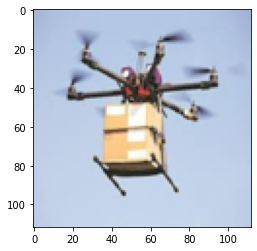

In [43]:
plt.imshow(lr_np)

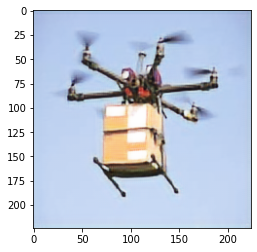

In [34]:
plt.imshow(sr_np)

## Converting image to Base64 for transferring over the Network for Rendering on HTML

In [36]:
from PIL import Image
import io
import base64

def img_to_base64(img):
    img = Image.fromarray(img, 'RGB') 
    buffer = io.BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()                     
    img_str = f"data:image/jpeg;base64,{base64.b64encode(myimage).decode()}"
    return img_str

''
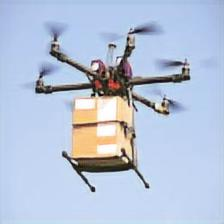

In [37]:
sr_np_norm = np.uint8(sr_np*255)
img_str = img_to_base64(sr_np_norm)
img_str

In [38]:
# How to use base64 encoded images?
img_bytes = base64.b64decode(img_str.split(',')[1])
img = Image.open(io.BytesIO(img_bytes))
img = np.array(img)

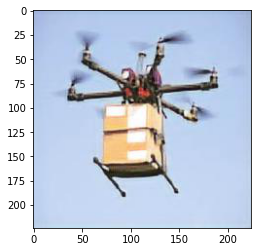

In [39]:
plt.imshow(img)